Notebook 02 – Entrenamiento de Modelos RNN (LSTM/GRU)
Versión lista para pegar en Jupyter – Español + Inglés

Incluye:

Carga correcta desde data/raw_npy/

Uso del demo GitHub (200 muestras por clase) o Zenodo (120k)

Carga automática de configuraciones JSON

Construcción del modelo

Entrenamiento con métricas

Guardado del modelo y metadatos

Estructura limpia y modular (como un artículo reproducible)

In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [15]:

# =========================
# CONFIGURACIÓN GENERAL
# =========================

# Directorio base del repositorio
BASE_DIR = "/Users/armandobecerril/PhD/MSL-150"

# Nº de frames por secuencia y muestras por clase
frames = 30
samples = 800   # usa 800 para dataset completo de Zenodo, 200 si trabajas solo con el subset

# -------------------------
# RUTAS DE DATOS
# -------------------------

# Ruta donde están los .npy completos descargados desde Zenodo
# Estructura esperada: data/raw_npy/<palabra>/<secuencia>/<frame>.npy
DATA_PATH = os.path.join(BASE_DIR, "data", "raw_npy")

# Ruta al archivo de términos (diccionario de vocabulario)
TERMS_PATH = os.path.join(BASE_DIR, "data", "dictionary", "terms.txt")

# -------------------------
# RUTAS DE MODELOS Y MÉTRICAS
# -------------------------

# Carpeta para guardar modelos entrenados
MODELS_BASE_DIR = os.path.join(BASE_DIR, "models", "trained_models")

# Carpeta para guardar el CSV de métricas
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")

os.makedirs(MODELS_BASE_DIR, exist_ok=True)
os.makedirs(PERFORMANCE_DIR, exist_ok=True)

print("BASE_DIR        :", BASE_DIR)
print("DATA_PATH       :", DATA_PATH)
print("TERMS_PATH      :", TERMS_PATH)
print("MODELS_BASE_DIR :", MODELS_BASE_DIR)
print("PERFORMANCE_DIR :", PERFORMANCE_DIR)


BASE_DIR        : /Users/armandobecerril/PhD/MSL-150
DATA_PATH       : /Users/armandobecerril/PhD/MSL-150/data/raw_npy
TERMS_PATH      : /Users/armandobecerril/PhD/MSL-150/data/dictionary/terms.txt
MODELS_BASE_DIR : /Users/armandobecerril/PhD/MSL-150/models/trained_models
PERFORMANCE_DIR : /Users/armandobecerril/PhD/MSL-150/docs/performance


In [3]:
# Leer términos desde TERMS_PATH y construir el diccionario de vocabulario
videos_dict_aug = {}

with open(TERMS_PATH, 'r') as f:
    for line in f:
        term = line.strip()
        if term:
            videos_dict_aug[term] = samples  # p.ej. 800 o 200 según tu escenario

print("Número de términos en videos_dict_aug:", len(videos_dict_aug))
list(videos_dict_aug.items())[:10]


Número de términos en videos_dict_aug: 150


[('hospital', 800),
 ('si', 800),
 ('duro', 800),
 ('lunes', 800),
 ('perro', 800),
 ('cansado', 800),
 ('ayer', 800),
 ('yo', 800),
 ('nosotros', 800),
 ('beber', 800)]

In [4]:
# ---------------------------------------------------------
# Carga de secuencias (X) y etiquetas (y) desde los .npy
# ---------------------------------------------------------

# Mapeo de las acciones a números
label_map = {label: num for num, label in enumerate(videos_dict_aug.keys())}

sequences, labels = [], []

for action, n_sequences in videos_dict_aug.items():
    action_path = os.path.join(DATA_PATH, action)  # carpeta de la acción

    for sequence in range(n_sequences):
        sequence_path = os.path.join(action_path, str(sequence))  # carpeta de la secuencia
        window = []

        for frame_num in range(frames):  # normalmente 30
            res_path = os.path.join(sequence_path, f"{frame_num}.npy")
            if os.path.exists(res_path):
                res = np.load(res_path, allow_pickle=True)
                window.append(res)

        # Solo aceptamos ventanas completas
        if len(window) == frames:
            sequences.append(window)
            labels.append(label_map[action])

# Convertir a arrays NumPy
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Verificar dimensiones
if X.shape[0] != y.shape[0]:
    raise ValueError("Las dimensiones de X e y no coinciden. Verifique la extracción de datos.")

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)
print("Número total de acciones:", len(label_map))


Shape de X: (115480, 30, 226)
Shape de y: (115480, 150)
Shape de X_train: (92384, 30, 226)
Shape de y_train: (92384, 150)
Shape de X_test: (23096, 30, 226)
Shape de y_test: (23096, 150)
Número total de acciones: 150


In [5]:
sample = np.array(X_train[0])
input_dim = sample.shape[1]
print(f"Dimensión de input: {input_dim}")

Dimensión de input: 226


In [6]:
lsm_health_actions = np.array(list(videos_dict_aug.keys()))
print(lsm_health_actions)

['hospital' 'si' 'duro' 'lunes' 'perro' 'cansado' 'ayer' 'yo' 'nosotros'
 'beber' 'ambulancia' 'infeccion' 'ojo' 'no' 'pregunta' 'duda' 'bien'
 'mal' 'suave' 'normal' 'frio' 'caliente' 'mejor' 'peor' 'estresado'
 'rapido' 'lento' 'martes' 'miercoles' 'jueves' 'viernes' 'sabado'
 'domingo' 'gato' 'camaron' 'pollo' 'abeja' 'confundido' 'ahora' 'hoy'
 'manana' 'nunca' 'siempre' 'diario' 'mama' 'papa' 'esposo' 'esposa'
 'hijo' 'hija' 'enero' 'febrero' 'marzo' 'abril' 'mayo' 'junio' 'julio'
 'agosto' 'septiembre' 'octubre' 'noviembre' 'diciembre' '1' '2' '3' '4'
 '5' '6' '7' '8' '9' '10' 'como' 'cuantos' 'para_que' 'por_que' 'cocinar'
 'recibir' 'estudiar' 'interpretar' 'ir' 'no_ver' 'dormir' 'pelear'
 'trabajar' 'descansar' 'comer' 'correr' 'caminar' 'jarabe' 'virus'
 'aborto' 'accidente' 'doctor' 'enfermera' 'enfermero' 'paciente'
 'enfermo' 'terapia' 'pastillas' 'inyeccion' 'contagiar' 'revisar'
 'calentura' 'cancer' 'infarto' 'lesion' 'embarazo' 'sangre' 'gripa'
 'garganta' 'tos' 'debil

# GPU Validation

In [7]:
tf.test.is_built_with_cuda() 
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
gpu = len(tf.config.list_physical_devices('GPU'))>0 
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print("Num GPUs disponbles: ", len(tf.config.experimental.list_physical_devices('GPU')) )

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Num GPUs disponbles:  1


# Build Neural Networks

In [8]:
import os
import json

def generate_model_configs():
    """
    Carga automáticamente TODOS los archivos JSON dentro de:
        models/configs/
    y devuelve una lista de configuraciones de modelos.
    """
    
    CONFIG_DIR = os.path.join(BASE_DIR, "models", "configs")
    
    configs = []
    
    # Iterar sobre todos los JSON
    for filename in os.listdir(CONFIG_DIR):
        if filename.endswith(".json"):
            json_path = os.path.join(CONFIG_DIR, filename)
            
            with open(json_path, "r") as f:
                config = json.load(f)
            
            # Normalizamos los nombres por seguridad
            config["config_file"] = filename
            
            configs.append(config)
    
    # Orden opcional: por tipo de modelo y arquitectura
    configs = sorted(
        configs,
        key=lambda x: (x["type"], "-".join(map(str, x["units"])))
    )
    
    print(f"📄 {len(configs)} configuraciones cargadas desde models/configs/")
    return configs


In [9]:
model_configs = generate_model_configs()

print("Modelos disponibles:")
for cfg in model_configs:
    print(cfg["config_file"], "->", cfg["type"], cfg["units"])


📄 10 configuraciones cargadas desde models/configs/
Modelos disponibles:
config_GRU_128.json -> GRU [128]
config_GRU_128_128.json -> GRU [128, 128]
config_GRU_128_256_128.json -> GRU [128, 256, 128]
config_GRU_64.json -> GRU [64]
config_GRU_64_128.json -> GRU [64, 128]
config_LSTM_128.json -> LSTM [128]
config_LSTM_128_128.json -> LSTM [128, 128]
config_LSTM_128_256_128.json -> LSTM [128, 256, 128]
config_LSTM_64.json -> LSTM [64]
config_LSTM_64_128.json -> LSTM [64, 128]


In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# -------------------------------------------------------------------
# Paths del proyecto
# -------------------------------------------------------------------
BASE_DIR         = "/Users/armandobecerril/PhD/MSL-150"
MODELS_BASE_DIR  = os.path.join(BASE_DIR, "models", "trained_models")
PERFORMANCE_DIR  = os.path.join(BASE_DIR, "docs", "performance")   # aquí quedará PERFORMANCE_LSM_MODELS.csv

os.makedirs(MODELS_BASE_DIR, exist_ok=True)
os.makedirs(PERFORMANCE_DIR, exist_ok=True)

# -------------------------------------------------------------------
# Función para construir el modelo RNN (LSTM o GRU)
# -------------------------------------------------------------------
def build_model(model_type, units_config, dropout, input_shape, num_classes):
    """
    model_type   : 'LSTM' o 'GRU'
    units_config : lista de unidades por capa, p.ej. [64, 128]
    dropout      : tasa de dropout (si es None, se usa 0.5)
    input_shape  : (timesteps, num_features) -> (30, 226)
    num_classes  : número de clases (150)
    """
    if dropout is None:
        dropout = 0.5  # default si no viene en config

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(BatchNormalization())

    # Capas recurrentes
    for i, units in enumerate(units_config):
        layer = LSTM if model_type == "LSTM" else GRU
        return_seq = (i < len(units_config) - 1)
        model.add(layer(units,
                        return_sequences=return_seq,
                        kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout))

    # Capas densas finales
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dense(num_classes, activation="softmax"))

    return model

# -------------------------------------------------------------------
# Guardar resultados de desempeño en CSV
# -------------------------------------------------------------------
def save_results_to_csv(results, performance_dir):
    """
    results: lista de dicts con métricas por época
    """
    csv_file = os.path.join(performance_dir, "PERFORMANCE_LSM_MODELS.csv")

    df_new = pd.DataFrame(results)

    if os.path.exists(csv_file):
        df_existing = pd.read_csv(csv_file)
        df = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        df = df_new

    df.to_csv(csv_file, index=False)
    print(f"✅ Performance results updated: {csv_file}")

# -------------------------------------------------------------------
# Entrenamiento y guardado de todos los modelos definidos en configs
# -------------------------------------------------------------------
def train_and_save_models(model_configs, X_train, y_train, X_test, y_test,
                          models_base_dir=MODELS_BASE_DIR,
                          performance_dir=PERFORMANCE_DIR):
    """
    model_configs: lista de configs cargadas desde models/configs/*.json
    """
    num_classes = y_train.shape[1]
    input_shape = (X_train.shape[1], X_train.shape[2])  # (30, 226)

    experiment_count = 0

    for config in model_configs:
        experiment_count += 1
        print("\n" + "="*80)
        print(f"🚀 Starting experiment {experiment_count} / {len(model_configs)}")
        print(f"   Config file : {config.get('config_file', 'N/A')}")
        print(f"   Model       : {config['type']} {config['units']}")
        print("="*80)

        # Nombre del modelo según arquitectura
        model_name = f"{config['type']}_{'_'.join(map(str, config['units']))}"

        # Directorio donde se guardará este modelo específico
        model_dir = os.path.join(models_base_dir, model_name)
        os.makedirs(model_dir, exist_ok=True)

        # TensorBoard
        tb_callback = TensorBoard(log_dir=model_dir, update_freq="batch")

        # Construcción y compilación
        model = build_model(
            model_type   = config["type"],
            units_config = config["units"],
            dropout      = config["dropout"],
            input_shape  = input_shape,
            num_classes  = num_classes
        )

        model.compile(
            optimizer = Adam(learning_rate=config["learning_rate"]),
            loss      = "categorical_crossentropy",
            metrics   = ["accuracy"]
        )

        # Early Stopping
        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )

        # Entrenamiento
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs     = config["epochs"],
            batch_size = config["batch_size"],
            callbacks  = [early_stopping, tb_callback],
            verbose    = 1
        )

        # ¿Hubo early stopping?
        early_stopping_flag = early_stopping.stopped_epoch > 0

        # Guardar modelo entrenado
        model_filename = os.path.join(model_dir, f"{model_name}.h5")
        model.save(model_filename)
        print(f"💾 Model saved at: {model_filename}")

        # Métricas por época
        accuracy_per_epoch    = history.history["accuracy"]
        val_accuracy_per_epoch = history.history["val_accuracy"]

        # Predicciones finales en test para métricas globales
        y_pred        = model.predict(X_test)
        y_pred_cls    = np.argmax(y_pred, axis=1)
        y_true_cls    = np.argmax(y_test, axis=1)

        precision = precision_score(y_true_cls, y_pred_cls,
                                    average="macro", zero_division=1)
        recall    = recall_score(y_true_cls, y_pred_cls,
                                 average="macro", zero_division=1)

        try:
            auc = roc_auc_score(y_test, y_pred,
                                multi_class="ovr", average="macro")
        except ValueError:
            auc = np.nan

        # Guardar resultados por época (con mismas métricas globales)
        results = []
        for epoch_idx in range(len(accuracy_per_epoch)):
            epoch_results = {
                "experiment_id":  experiment_count,
                "config_file":    config.get("config_file", ""),
                "model_type":     config["type"],
                "units":          "-".join(map(str, config["units"])),
                "learning_rate":  config["learning_rate"],
                "batch_size":     config["batch_size"],
                "epochs":         config["epochs"],
                "dropout":        config["dropout"],
                "epoch":          epoch_idx + 1,
                "accuracy":       accuracy_per_epoch[epoch_idx],
                "val_accuracy":   val_accuracy_per_epoch[epoch_idx],
                "precision":      precision,
                "recall":         recall,
                "auc":            auc,
                "early_stopping": early_stopping_flag
            }
            results.append(epoch_results)

        save_results_to_csv(results, performance_dir)

        # Liberar recursos
        tf.keras.backend.clear_session()
        del model
        print(f"✅ Experiment {experiment_count} completed and resources released.")


In [12]:
# 1) Cargar configs desde models/configs/
model_configs = generate_model_configs()

# 2) Entrenar todos los modelos y guardar resultados
train_and_save_models(model_configs, X_train, y_train, X_test, y_test)


📄 10 configuraciones cargadas desde models/configs/

🚀 Starting experiment 1 / 10
   Config file : config_GRU_128.json
   Model       : GRU [128]


Epoch 1/25
2887/2887 [==============================] - 64s 22ms/step - loss: 2.3606 - accuracy: 0.5911 - val_loss: 1.2912 - val_accuracy: 0.8516
Epoch 2/25
2887/2887 [==============================] - 54s 19ms/step - loss: 1.2792 - accuracy: 0.8368 - val_loss: 0.9732 - val_accuracy: 0.9015
Epoch 3/25
2885/2887 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.8764

KeyboardInterrupt: 

# Model Results and performace

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load performance file
# ---------------------------------------------------------
BASE_DIR        = "/Users/armandobecerril/PhD/MSL-150"
PERFORMANCE_DIR = os.path.join(BASE_DIR, "docs", "performance")
FIGURES_DIR     = os.path.join(BASE_DIR, "docs", "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

csv_file        = os.path.join(PERFORMANCE_DIR, "PERFORMANCE_LSM_MODELS.csv")

df = pd.read_csv(csv_file)
print(f"Rows loaded: {df.shape[0]}")
display(df.head())

# ---------------------------------------------------------
# 2. Helper: optional filtering by model_version
#    (currently model_version is NaN, so by default we use all rows)
# ---------------------------------------------------------
def filter_by_model_version(df, model_version=None):
    """
    If model_version is None, returns the full dataframe.
    If model_version is provided and the column exists, filters by that value.
    """
    if model_version is None:
        return df.copy()

    if "model_version" not in df.columns:
        print("Column 'model_version' not found. Using all rows.")
        return df.copy()

    filtered = df[df["model_version"] == model_version]
    if filtered.empty:
        print(f"No rows found for model_version = {model_version}. Using all rows instead.")
        return df.copy()

    return filtered

# ---------------------------------------------------------
# 3. Color palette for up to 10 experiments
# ---------------------------------------------------------
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

# ---------------------------------------------------------
# 4. Accuracy per epoch (training) – all experiments
# ---------------------------------------------------------
def plot_accuracy_only(df, model_version=None, save_path=None):
    """
    Plot training accuracy per epoch for all experiments.
    One line per experiment_id, color-coded.
    If save_path is provided, saves the figure at 600 dpi.
    """
    filtered_df = filter_by_model_version(df, model_version)
    if filtered_df.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(12, 6))

    experiment_ids = sorted(filtered_df['experiment_id'].unique())
    experiment_colors = {
        exp: color_list[i % len(color_list)]
        for i, exp in enumerate(experiment_ids)
    }

    for experiment_id in experiment_ids:
        subset = filtered_df[filtered_df['experiment_id'] == experiment_id]
        model_type = subset['model_type'].iloc[0]  # 'LSTM' or 'GRU'

        plt.plot(
            subset['epoch'], subset['accuracy'],
            color=experiment_colors[experiment_id],
            marker='o', linestyle='-',
            label=f'Exp {experiment_id} – {model_type}',
            markersize=3, alpha=0.9
        )

    title_suffix = f"(version {model_version})" if model_version is not None else ""
    plt.title(f'Accuracy per Epoch {title_suffix}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.3)

    # Legend outside the plot to avoid cluttering
    plt.legend(
        title='Experiments',
        title_fontsize=11,
        loc='upper left',
        fontsize=9,
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.
    )

    plt.tight_layout()

    # Save at 600 dpi for publication
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()

# ---------------------------------------------------------
# 5. Validation Accuracy per epoch – all experiments
# ---------------------------------------------------------
def plot_val_accuracy_only(df, model_version=None, save_path=None):
    """
    Plot validation accuracy per epoch for all experiments.
    One line per experiment_id, color-coded.
    If save_path is provided, saves the figure at 600 dpi.
    """
    filtered_df = filter_by_model_version(df, model_version)
    if filtered_df.empty:
        print("No data to plot.")
        return

    plt.figure(figsize=(12, 6))

    experiment_ids = sorted(filtered_df['experiment_id'].unique())
    experiment_colors = {
        exp: color_list[i % len(color_list)]
        for i, exp in enumerate(experiment_ids)
    }

    for experiment_id in experiment_ids:
        subset = filtered_df[filtered_df['experiment_id'] == experiment_id]
        model_type = subset['model_type'].iloc[0]

        plt.plot(
            subset['epoch'], subset['val_accuracy'],
            color=experiment_colors[experiment_id],
            marker='s', linestyle='--',
            label=f'Exp {experiment_id} – {model_type}',
            markersize=3, alpha=0.9
        )

    title_suffix = f"(version {model_version})" if model_version is not None else ""
    plt.title(f'Validation Accuracy per Epoch {title_suffix}', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Validation Accuracy', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.3)

    plt.legend(
        title='Experiments',
        title_fontsize=11,
        loc='upper left',
        fontsize=9,
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=0.
    )

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()


Rows loaded: 250


,experiment_id,model_version,model_type,units,learning_rate,batch_size,epochs,dropout,epoch,accuracy,val_accuracy,precision,recall,auc,early_stopping
0,1,NaN,LSTM,128,0.001,32,25,NaN,1,0.583802,0.844735,0.975758,0.962237,0.999913,False
1,1,NaN,LSTM,128,0.001,32,25,NaN,2,0.835112,0.910331,0.975758,0.962237,0.999913,False
2,1,NaN,LSTM,128,0.001,32,25,NaN,3,0.868159,0.932369,0.975758,0.962237,0.999913,False
3,1,NaN,LSTM,128,0.001,32,25,NaN,4,0.892828,0.935443,0.975758,0.962237,0.999913,False
4,1,NaN,LSTM,128,0.001,32,25,NaN,5,0.901823,0.947393,0.975758,0.962237,0.999913,False


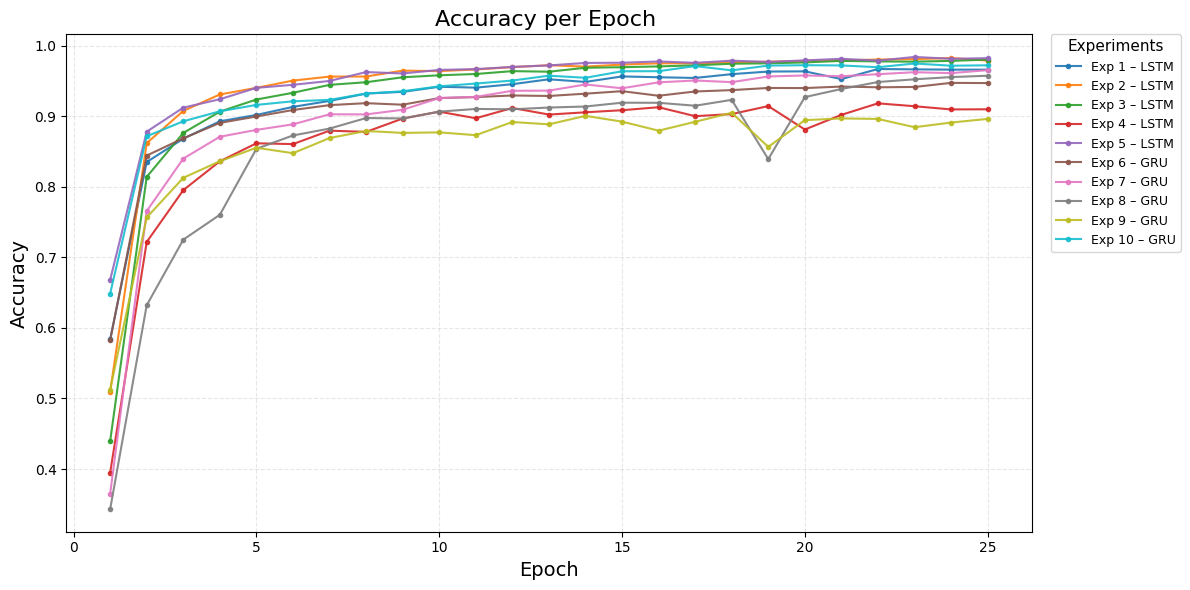

In [58]:
plot_accuracy_only(
    df,
    model_version=None,
    save_path=os.path.join(FIGURES_DIR, "accuracy_per_epoch_all.png")
)

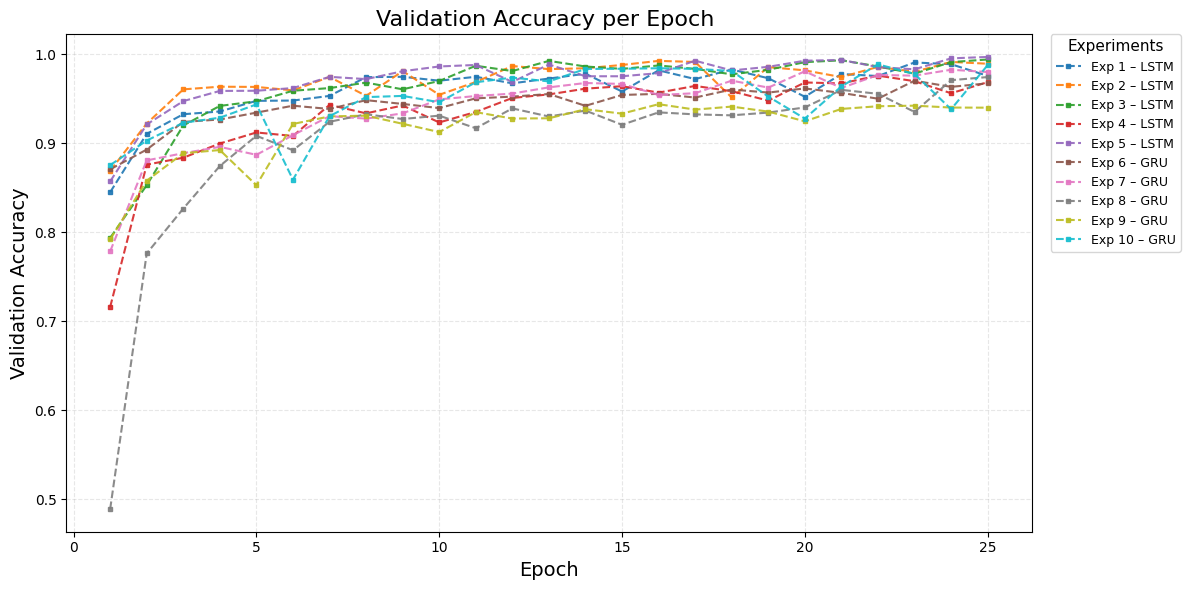

In [59]:
plot_val_accuracy_only(
    df,
    model_version=None,
    save_path=os.path.join(FIGURES_DIR, "val_accuracy_per_epoch_all.png")
)